# Statistics

In [1]:
%%javascript
require("notebook/js/notebook").Notebook.prototype.scroll_to_bottom = function () {}

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from glob import glob 
import pickle
from IPython.display import display
import seaborn as sns
import numpy as np
import sklearn
from sklearn import dummy
import sys
import os
import helper

EXPORT_DPI = 100
EXPORT_FIG_SIZE = (8, 4)
EXPORT_FIG_SIZE_BIG = (10, 7)
EXPORT_FIG_WIDTH, EXPORT_FIG_HEIGHT = EXPORT_FIG_SIZE
EXPORT_FIG_WIDTH_BIG, EXPORT_FIG_HEIGHT_BIG = EXPORT_FIG_SIZE_BIG

plt.rcParams['figure.figsize'] = EXPORT_FIG_SIZE_BIG

import seaborn as sns
sns.set('notebook', 'whitegrid')

In [3]:
pd.options.display.max_columns = 999

In [4]:
ALREADY_LOADED = []
df_all_ = None

## Retrieve results

In [37]:
import collections
USED_FOLDER = '2017-09-13_21:33'
USED_FOLDER = None

USE_ALREADY_LOADED = True
if not USE_ALREADY_LOADED:
    ALREADY_LOADED = []
    df_all_ = None

result_folders = [x for x in glob('data/results/2017*') if os.path.isdir(x)]

folder = 'data/results/{}'.format(USED_FOLDER) if USED_FOLDER else result_folders[-1]

print('Using result folder: {}'.format(folder))

cache_counter = collections.Counter()
for result_file in helper.log_progress(glob('{}/*.npy'.format(folder))):
    filename = result_file.split('/')[-1]
    if filename in ALREADY_LOADED:
        cache_counter['cached'] += 1
        continue
    cache_counter['loaded'] += 1
    ALREADY_LOADED.append(filename)
    with open(result_file, 'rb') as f:
        result = pickle.load(f)

    dataset = result_file.split('/')[-1].rsplit('.', 2)[0]
    is_graph_dataset = 'graph' in dataset
    is_cooccurrence_dataset = 'cooccurrence' in dataset
    dataset_name = dataset
    
    result['combined'] = 'combined' in result_file
    if is_graph_dataset:
        is_lemmatized = '_lemmatized_' in result_file
        result['lemmatized'] = is_lemmatized
        
        result['same_label'] = 'same-label' in result_file
        is_simple_kernel = '.simple.' in result_file
        if is_simple_kernel:
            result['kernel'] = 'simple_set_matching'
        else:
            result['kernel'] = 'spgk' if 'spgk' in result_file else 'wl'
        is_relabeled = 'relabeled' in result_file
        result['relabeled'] = is_relabeled
        if is_relabeled:
            topn = result_file.split('topn-')[1].split('_')[0]
            threshold = result_file.split('threshold-')[1].split('_')[0]
            result['topn'] = int(topn)
            result['threshold'] = float(threshold)
        if result['kernel'] == 'wl':
            result['wl_iteration'] = dataset.split('.')[-1]
        parts = dataset.split('_')
        if is_cooccurrence_dataset:
            dataset_name = parts[-1].split('_')[0].split('.')[0]
            result['words'] = parts[4]
            result['window_size'] = parts[3]
        # GML
        else:
            dataset_name = parts[-1].split('.')[0]
            result['words'] = 'concepts'
        result['type'] = 'cooccurrence' if is_cooccurrence_dataset else 'concept-graph'
    else:
        result['type'] = 'text'
        dataset_name = dataset.split('_')[1]
        result['words'] = ['all' for x in result['params']]

    result['classifier'] = [None] * len(result['params'])
    for idx, param in enumerate(result['params']):
        result['classifier'][idx] = type(param['clf']).__name__
        del param['clf']
    
    dataset_name = dataset_name.replace('-single', '').replace('-ana', '').strip()

    if '-ana' in result_file:
        result['is_ana'] = True
    
    if dataset_name.endswith('-single') or dataset_name.endswith('-ana'):
        dataset_name = dataset_name.rsplit('-', 1)[0]
        
    result['filename'] = result_file
    result['dataset'] = dataset_name

    del result['param_clf']
    
    result_df = pd.DataFrame(result).sort_values(by = 'dataset', ascending = False)
    df_all_ = result_df if df_all_ is None else df_all_.append(result_df)

assert df_all_ is not None
assert df_all_.shape[0]
    
# Only keep datasets where there are all three types (text, co-occurence and concept-graph) of results
df_all = df_all_.groupby('dataset').filter(lambda x: len(x.type.value_counts()) == 3).reset_index(drop=True)
print(cache_counter)

Using result folder: data/results/2017-10-01_16-58


Counter({'cached': 5751, 'loaded': 25})


In [19]:
df_results = pd.DataFrame([(folder.split('/')[-1], len(glob('{}/*.npy'.format(folder)))) for folder in result_folders], columns = ['result_folder', 'num_results']).set_index('result_folder').sort_index()
df_results.tail()

,num_results
result_folder,
2017-09-30_20-45,4235
2017-09-30_21-29,4305
2017-09-30_23-57,4537
2017-10-01_11-23,5446
2017-10-01_15-49,5746


In [20]:
sns.set('notebook', 'whitegrid', palette='deep')

## DummyClassifier performance per dataset

In [21]:
df_all[df_all.classifier == 'DummyClassifier'].groupby('dataset').mean_test_f1_macro.max().to_frame()

,mean_test_f1_macro
dataset,
ling-spam,0.458532
ng20,0.005613
reuters-21578,0.005215
webkb,0.140260


## Result distributions

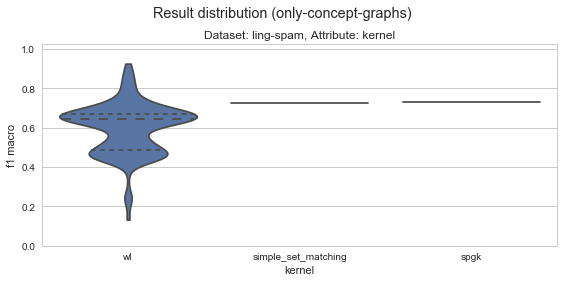

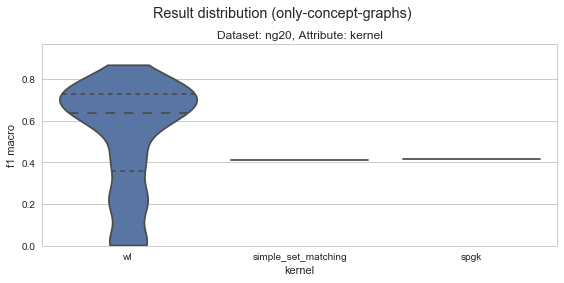

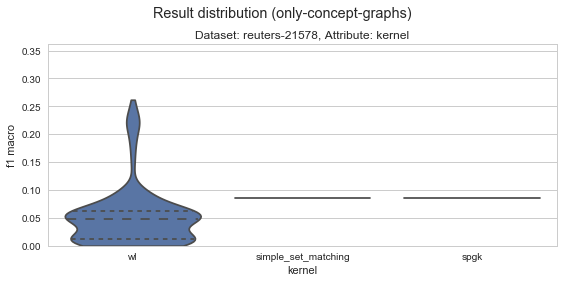

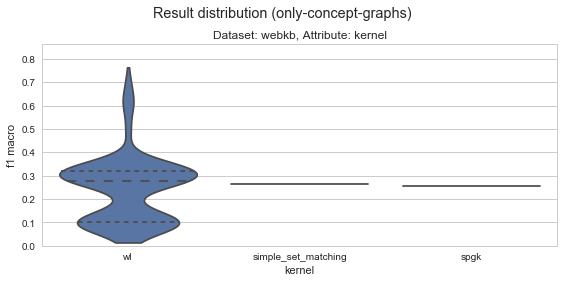

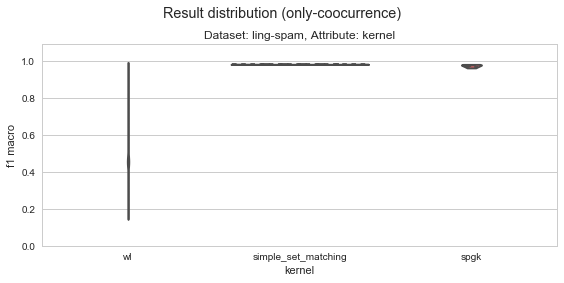

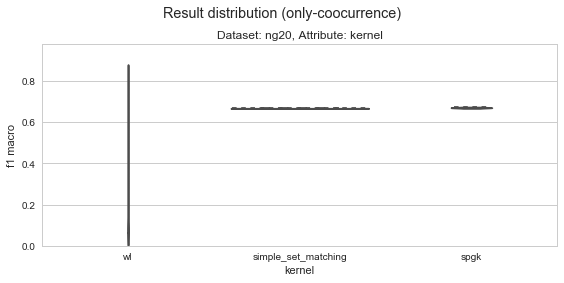

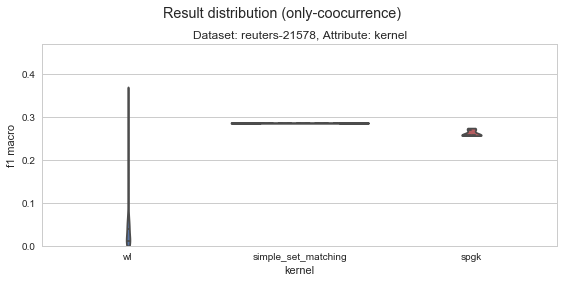

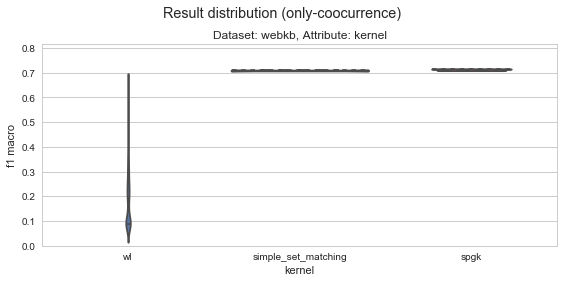

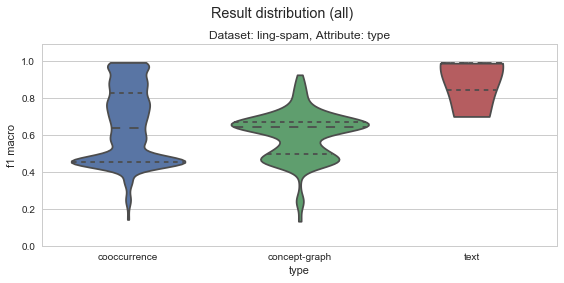

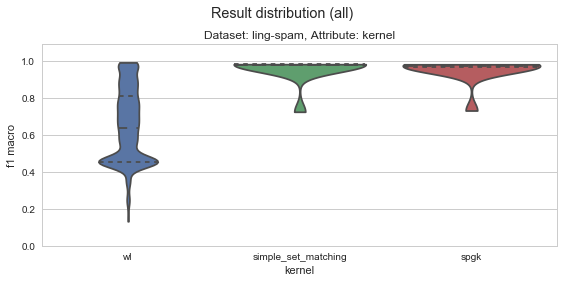

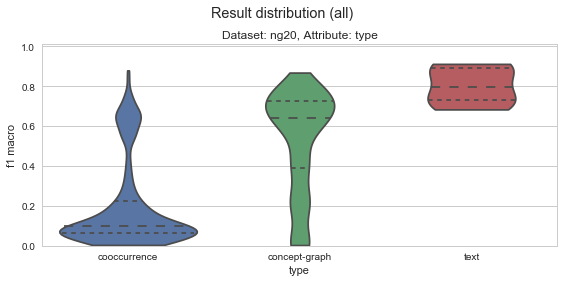

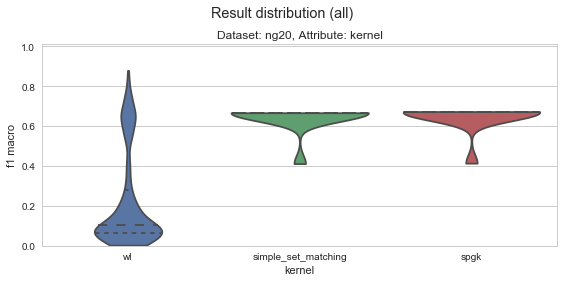

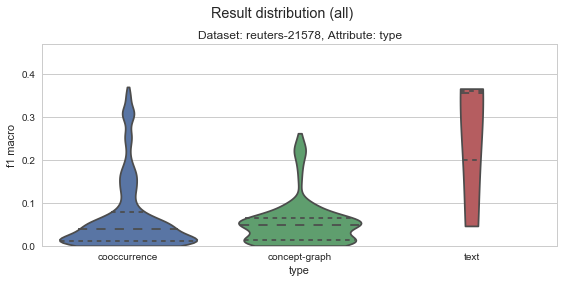

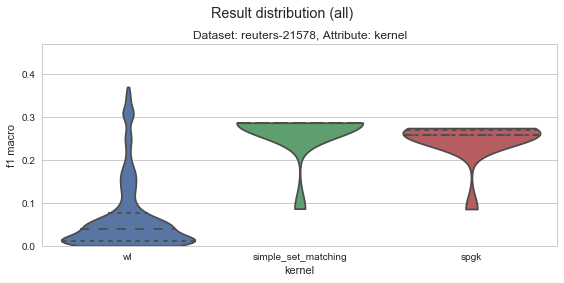

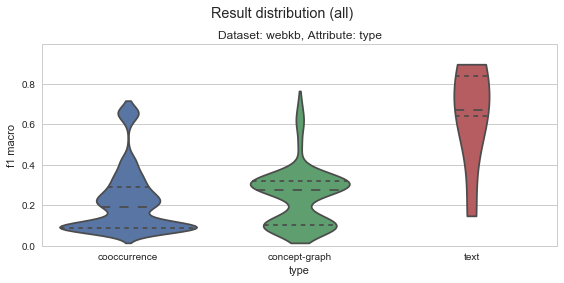

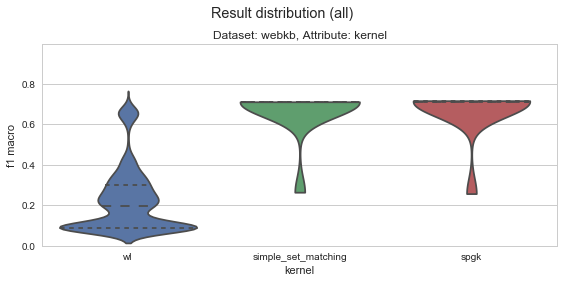

In [22]:
for data_filter_name, data_filter in [('only-concept-graphs', df_all.type == 'concept-graph'), ('only-coocurrence', df_all.type == 'cooccurrence'), ('all', df_all.type != 'YES')]:
    for dataset_name, df in df_all[data_filter].groupby('dataset'):
        for attr in ['type', 'kernel']:
            # Filter out DummyClassifier
            df = df[(df.classifier != 'DummyClassifier')]
            if len(df[attr].value_counts().tolist()) <= 1:
                continue
            
            f1_min, f1_max = df.mean_test_f1_macro.min(), df.mean_test_f1_macro.max()
            fig, axes = plt.subplots(figsize = EXPORT_FIG_SIZE)
            ax = sns.violinplot(x = attr, y = 'mean_test_f1_macro', data=df, cut = 0, split = True, inner = 'quartile')
            ax.set_ylim((0, f1_max + 0.1))
            ax.set_ylabel('f1 macro')
            fig.suptitle('Result distribution ({})'.format(data_filter_name));
            ax.set_title('Dataset: {}, Attribute: {}'.format(dataset_name, attr))
            fig.tight_layout()
            fig.subplots_adjust(top = 0.85)
            fig.savefig('tmp/result-distributions/{}-{}-{}.png'.format(dataset_name, data_filter_name, attr), dpi = EXPORT_DPI)
            plt.show()
            plt.close(fig)

## Best classifers per type per dataset

################# ling-spam


,classifier,dataset,filename,lemmatized,accuracy,f1,precision,recall,mean_train_f1_macro,param_scaler,params,relabeled,same_label,threshold,topn,window_size,wl_iteration,words,combined
type,,,,,,,,,,,,,,,,,,,
concept-graph,MultinomialNB,ling-spam,data/results/2017-10-01_15-37/dataset_graph_gm...,False,0.961481,0.926477,0.923039,0.930294,0.993458,None,{'scaler': None},False,False,NaN,NaN,NaN,6,concepts,False
cooccurrence,PassiveAggressiveClassifier,ling-spam,data/results/2017-10-01_15-37/dataset_graph_co...,True,0.996543,0.993737,0.995422,0.992100,1.000000,NaN,{},False,True,NaN,NaN,3,4,only-nouns,True
text,PassiveAggressiveClassifier,ling-spam,data/results/2017-10-01_15-37/text_ling-spam.r...,NaN,0.994307,0.989756,0.988943,0.990701,1.000000,NaN,{},NaN,NaN,NaN,NaN,NaN,NaN,all,False


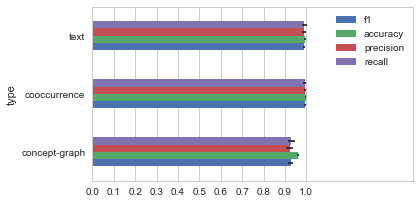

################# ng20


,classifier,dataset,filename,lemmatized,accuracy,f1,precision,recall,mean_train_f1_macro,param_scaler,params,relabeled,same_label,threshold,topn,window_size,wl_iteration,words,combined
type,,,,,,,,,,,,,,,,,,,
concept-graph,MultinomialNB,ng20,data/results/2017-10-01_15-37/dataset_graph_gm...,False,0.870505,0.868927,0.876821,0.866073,0.995698,None,{'scaler': None},False,False,NaN,NaN,NaN,stacked,concepts,False
cooccurrence,LinearSVC,ng20,data/results/2017-10-01_15-37/dataset_graph_co...,False,0.881303,0.879939,0.881728,0.878878,0.999694,NaN,{},False,False,NaN,NaN,2,0,all,True
text,LinearSVC,ng20,data/results/2017-10-01_15-37/text_ng20-ana.re...,NaN,0.914672,0.912572,0.914259,0.911714,0.998895,NaN,{},NaN,NaN,NaN,NaN,NaN,NaN,all,False


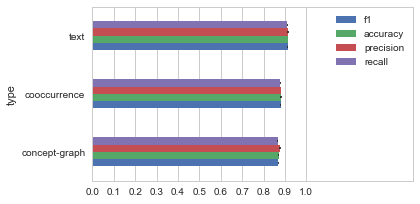

################# reuters-21578


,classifier,dataset,filename,lemmatized,accuracy,f1,precision,recall,mean_train_f1_macro,param_scaler,params,relabeled,same_label,threshold,topn,window_size,wl_iteration,words,combined
type,,,,,,,,,,,,,,,,,,,
concept-graph,MultinomialNB,reuters-21578,data/results/2017-10-01_15-37/dataset_graph_gm...,False,0.645068,0.261841,0.312178,0.241450,0.655145,None,{'scaler': None},False,False,NaN,NaN,NaN,stacked,concepts,False
cooccurrence,LinearSVC,reuters-21578,data/results/2017-10-01_15-37/dataset_graph_co...,True,0.684949,0.369677,0.336371,0.486782,0.556030,"Normalizer(copy=True, norm='l1')","{'scaler': Normalizer(copy=True, norm='l1')}",True,False,0.99,5.0,3,0,only-nouns,False
text,LinearSVC,reuters-21578,data/results/2017-10-01_15-37/text_reuters-215...,NaN,0.692355,0.365727,0.358199,0.395505,0.694682,NaN,{},NaN,NaN,NaN,NaN,NaN,NaN,all,False


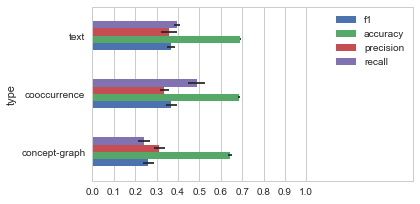

################# webkb


,classifier,dataset,filename,lemmatized,accuracy,f1,precision,recall,mean_train_f1_macro,param_scaler,params,relabeled,same_label,threshold,topn,window_size,wl_iteration,words,combined
type,,,,,,,,,,,,,,,,,,,
concept-graph,MultinomialNB,webkb,data/results/2017-10-01_15-37/dataset_graph_gm...,False,0.816025,0.763539,0.772387,0.769722,0.985173,None,{'scaler': None},False,False,NaN,NaN,NaN,stacked,concepts,False
cooccurrence,SVC,webkb,data/results/2017-10-01_15-37/dataset_graph_co...,False,0.818709,0.715692,0.735567,0.714197,0.936644,NaN,{},False,False,NaN,NaN,1,NaN,all,False
text,LinearSVC,webkb,data/results/2017-10-01_15-37/text_webkb-ana.r...,NaN,0.906550,0.895274,0.900082,0.891651,0.996501,NaN,{},NaN,NaN,NaN,NaN,NaN,NaN,all,False


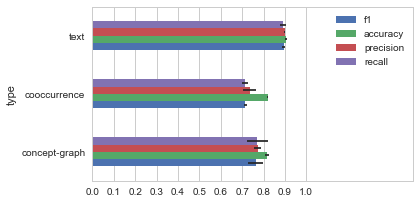

In [23]:
COLUMNS_OF_INTEREST = ['classifier', 'dataset', 'filename', 'lemmatized', 'accuracy', 'f1', 'precision', 'recall', 'mean_train_f1_macro', 'param_scaler', 'params', 'relabeled', 'same_label',
                       #, 'std_test_accuracy', 'std_test_f1_macro', 'std_test_precision_macro', 'std_test_recall_macro',
                       'threshold', 'topn', 'window_size', 'wl_iteration', 'words', 'combined']

def plot_best_by_type(df_all, df, df_dataset, title = '', fontsize = 12, figsize = (6, 3), top = 0.85):
    fig, ax = plt.subplots(figsize = figsize)
    els = df_all.iloc[df['mean_test_f1_macro'].idxmax()]
    els = els.set_index('type')
    els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
    els[['f1', 'accuracy', 'precision', 'recall']].plot(kind = 'barh', ax = ax, xlim = (0, 1.5), xerr=[els.std_test_f1_macro * 2,  els.std_test_accuracy * 2,  els.std_test_precision_macro * 2,  els.std_test_recall_macro * 2])
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.grid(axis = 'y')
    
    display(els[COLUMNS_OF_INTEREST])
    
    if title and title != '':
        fig.suptitle(title, fontsize = fontsize)
    fig.tight_layout()
    if title and title != '':
        fig.subplots_adjust(top = top)
    return fig, ax

for name, df_dataset in sorted(df_all[df_all.wl_iteration != 0].groupby('dataset'), key = lambda x: x[0]):
    df_dataset_grouped_by_type = df_dataset.groupby('type')
    print('################# {}'.format(name))
    use_title = False
    fig, ax = plot_best_by_type(df_all, df_dataset_grouped_by_type, df_dataset, 'Dataset: {}'.format(name) if use_title else None)
    fig.savefig('tmp/results/dataset-{}-best.png'.format(name), dpi = 150)
    plt.show()
    plt.close(fig)


## Plot best per parameter value per dataset

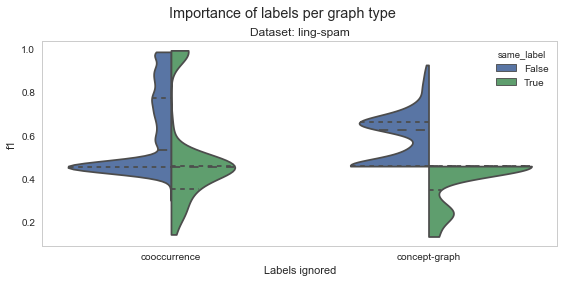

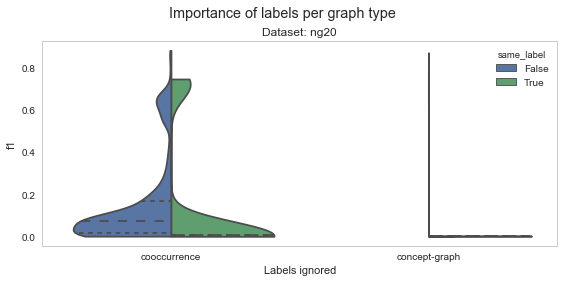

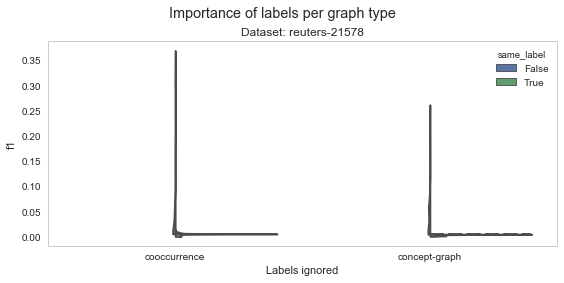

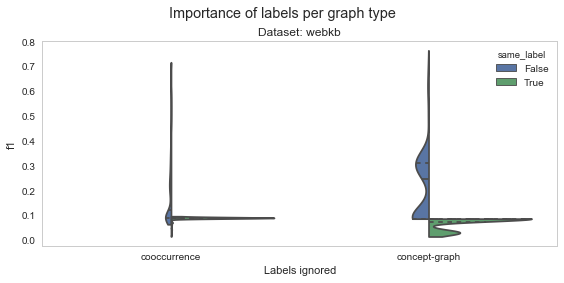

In [31]:
def graphs_grouped_by_plot(df_all, groupby):
    df_graphs_grouped = df_all[df_all.type != 'text'].groupby('dataset')

    for idx, (dataset_name, df_dataset) in enumerate(df_graphs_grouped):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize = EXPORT_FIG_SIZE)
        # Print violinplot of f1, with graph_type as hue
        hue = groupby if df_dataset[groupby].value_counts().count() > 1 else None
        sns.violinplot(x = 'type', y = 'mean_test_f1_macro', hue= hue , data=df_dataset, cut = 0, split = True, inner = 'quartile', title = dataset, ax = ax)
        #ax.set_ylim((0, 1.1))
        ax.set_title('Dataset: {}'.format(dataset_name))
        ax.set_ylabel('f1')
        ax.set_xlabel('Labels ignored')
        ax.grid('off')
        fig.tight_layout()
        fig.suptitle('Importance of labels per graph type')
        fig.subplots_adjust(top = 0.86)
        fig.savefig('tmp/results/label-importance-{}.png'.format(dataset_name), dpi = EXPORT_DPI)
        plt.show()

if 1 == 1:
    graphs_grouped_by_plot(df_all, 'same_label')

## Correlation matrix

In [34]:
import functools

def add(acc, item):
    acc += item
    return acc

def get_vals_for_col(col):
    return sorted(df_tmp[col].value_counts().index.tolist())

cols = ['combined', 'kernel', 'lemmatized', 'relabeled', 'threshold', 'type', 'window_size', 'wl_iteration', 'words', 'classifier', 'same_label', 'topn']
cols = ['type', 'wl_iteration']
cols = ['type', 'combined', 'kernel', 'wl_iteration', 'same_label']

df_tmp = df_all[df_all.dataset == 'ling-spam']#[cols + ['mean_test_f1_macro']]

vals = [get_vals_for_col(col) for col in cols]
val_lenghts = [len(vals_) for vals_ in vals]
dim = sum(val_lenghts)
vals_flattened = functools.reduce(add, vals, [])

best_of_mat = np.zeros((dim, dim), dtype=np.float32)

col_counter = 0
row_counter = 0

for col_idx1, col1 in enumerate(cols):
    vals_1 = get_vals_for_col(col1)
    col_counter = 0
    for col_idx2, col2 in enumerate(cols):
        vals_2 = get_vals_for_col(col2)
        for idx1, val1 in enumerate(vals_1):
            for idx2, val2 in enumerate(vals_2):
                best_of = df_tmp[(df_tmp[col1] == val1) & (df_tmp[col2] == val2)]
                best_f1 = best_of.mean_test_f1_macro.max()
                best_of_mat[row_counter + idx1, col_counter + idx2] = best_f1
        col_counter += len(vals_2)
    row_counter += len(vals_1)

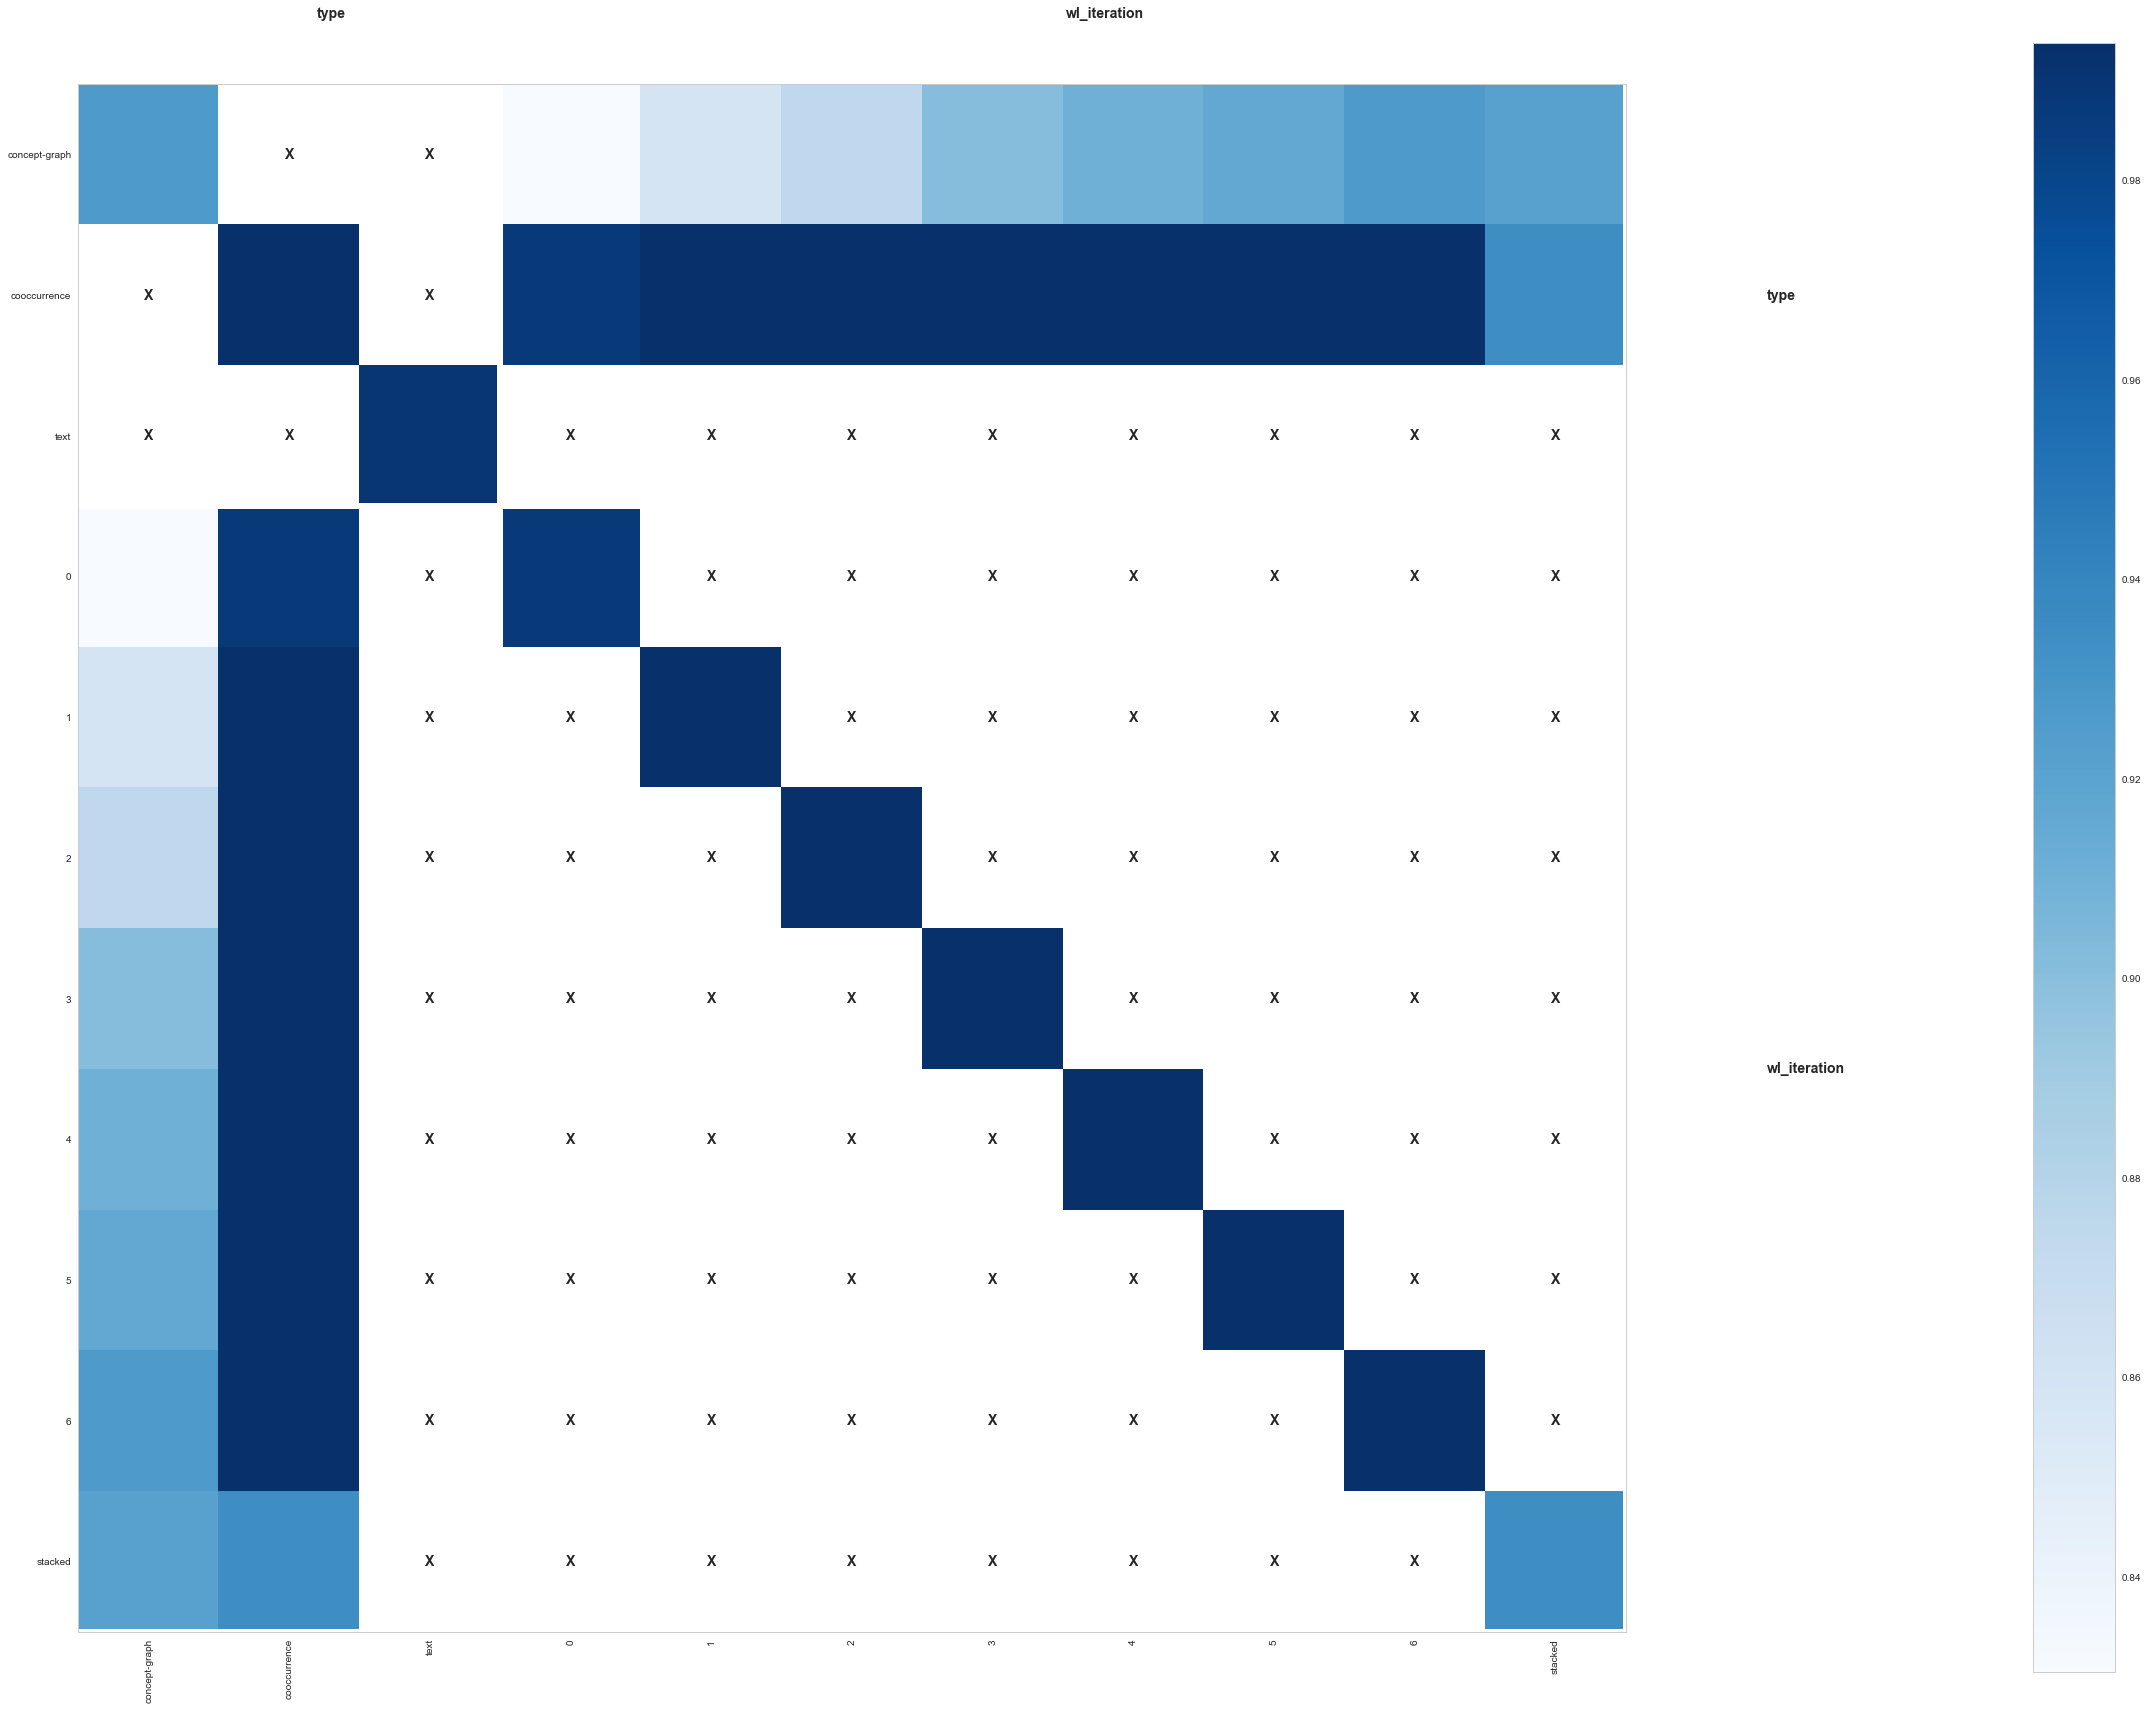

In [35]:
def plot(best_of_mat, vals, cols, ax = None, cmap='Blues', divider_color = '#FFFFFF', divider_linewidth = 6, fontdict = {'fontsize': 14, 'weight': 'bold'}):
    if not ax:
        fig, ax = plt.subplots()

    vals_lengths = [len(val) for val in vals]
    
    # Add labels to graph
    for idx, s in enumerate(np.cumsum(val_lenghts)):
        for x in ['v' , 'h']:
            getattr(plt, 'ax{}line'.format(x))(s - 0.5, color = divider_color, linewidth = divider_linewidth)
        
        text_offset = ((val_lenghts[idx]) / 2)
        
        # Add the col labels to the right
        ax.text(dim + 0.5, s - text_offset - 0.5, cols[idx], horizontalalignment = 'left', verticalalignment = 'center', fontdict=fontdict)
        # Add the col labels to the top
        ax.text(s - text_offset - 0.2, - 1, cols[idx], horizontalalignment = 'center', verticalalignment = 'center', fontdict=fontdict)

    # Add x- and y-ticks
    for x in ['x' , 'y']:
        getattr(plt, x + 'ticks')(range(len(vals_flattened)), vals_flattened)

    # Rotate x-ticks
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

    # Mark cells where no values are available
    for row, cell in (zip(*list(np.where(np.isnan(best_of_mat))))):
        ax.text(row, cell, 'X', horizontalalignment = 'center', verticalalignment = 'center', fontdict=fontdict)

    plt.grid('off')
    plt.imshow(best_of_mat, cmap=cmap)
    plt.colorbar(fraction=0.04, pad=0.2)

fig, ax = plt.subplots(figsize = (30, 30))
#plot(np.tril(best_of_mat), vals, cols, ax)
plot(best_of_mat, vals, cols, ax)
fig.tight_layout()
fig.savefig('tmp/correlations.png', dpi = EXPORT_DPI)

## Plot classifier performance

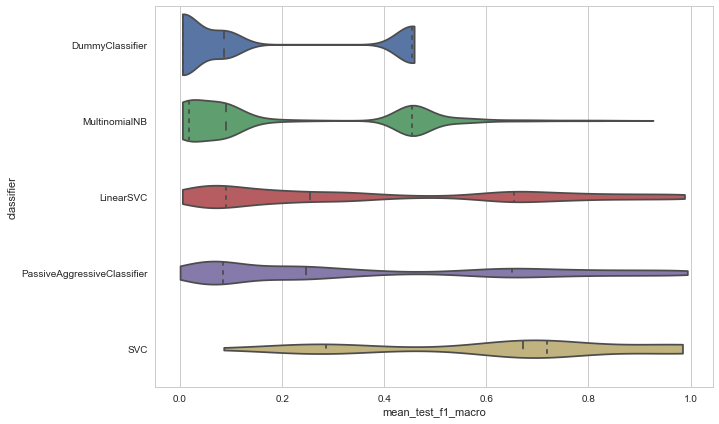

In [28]:
sns.violinplot(y = 'classifier', x = 'mean_test_f1_macro', data = df_all, cut = 0, split = True, inner = 'quartile', figsize = EXPORT_FIG_SIZE)
#for classifier, df_classifier in df_all[df_all.dataset == 'ling-spam'].groupby('classifier'):
#    print(classifier)

## Plot performance per dataset and wl_iteration and graph_type

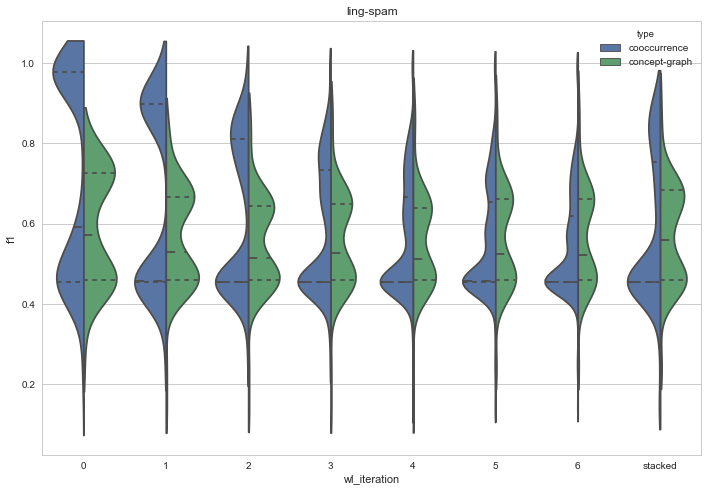

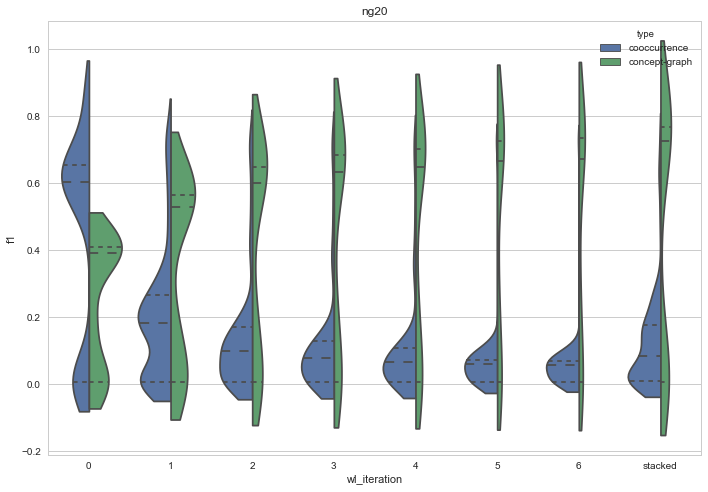

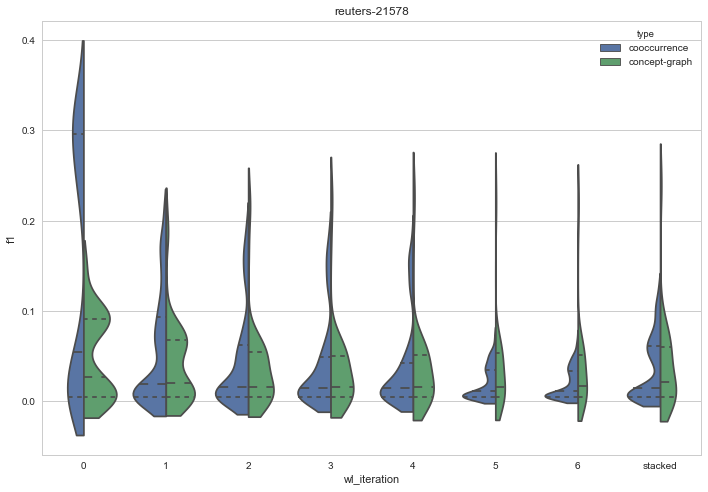

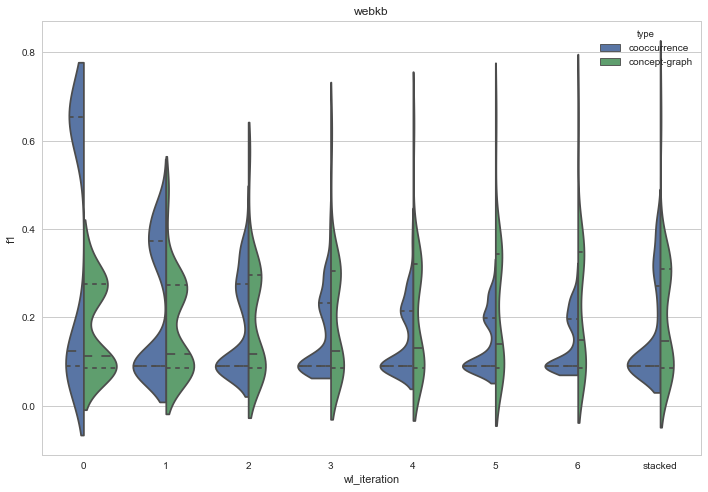

In [29]:
for dataset, df_tmp in df_all[(df_all.type != 'text') & (df_all.lemmatized != True)].sort_values('wl_iteration').groupby('dataset'):
    fig, ax = plt.subplots()
    ax = sns.violinplot(x = 'wl_iteration', y = 'mean_test_f1_macro', hue = 'type', split = True, data = df_tmp, cut = True, inner = 'quartile', figsize = EXPORT_FIG_SIZE)
    ax.set_ylabel('f1')
    ax.set_title(dataset)
    ax.figure.tight_layout()
    plt.show()
    plt.close(fig)
#.groupby('wl_iteration').mean_test_f1_macro.plot(kind = 'hist', alpha = 0.5, legend = True)

## Plot by parameter

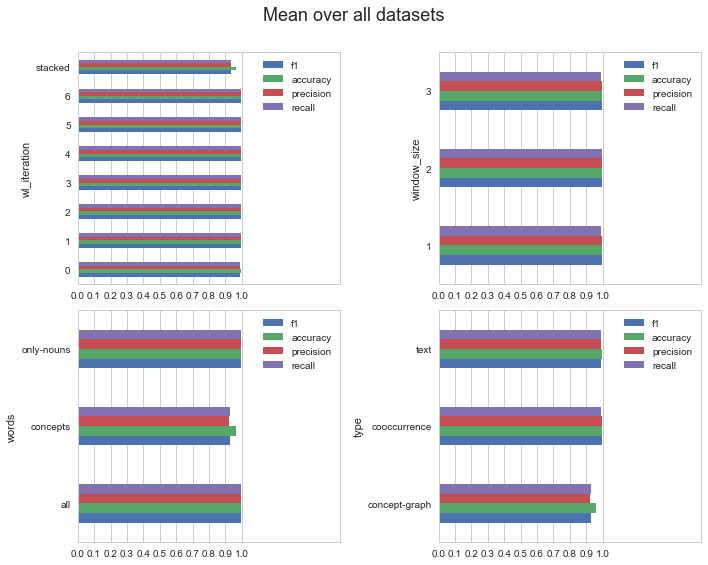

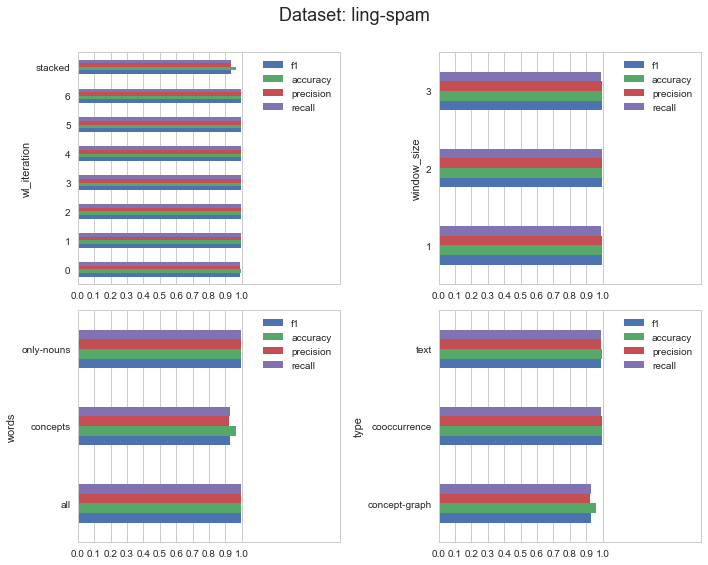

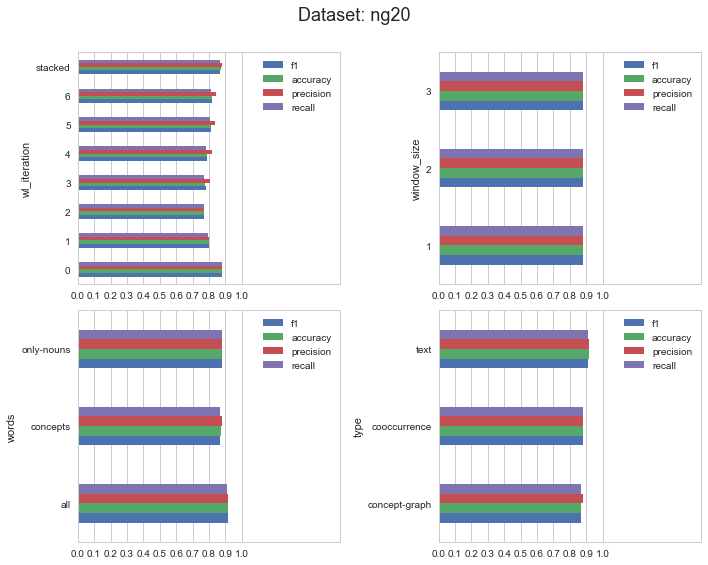

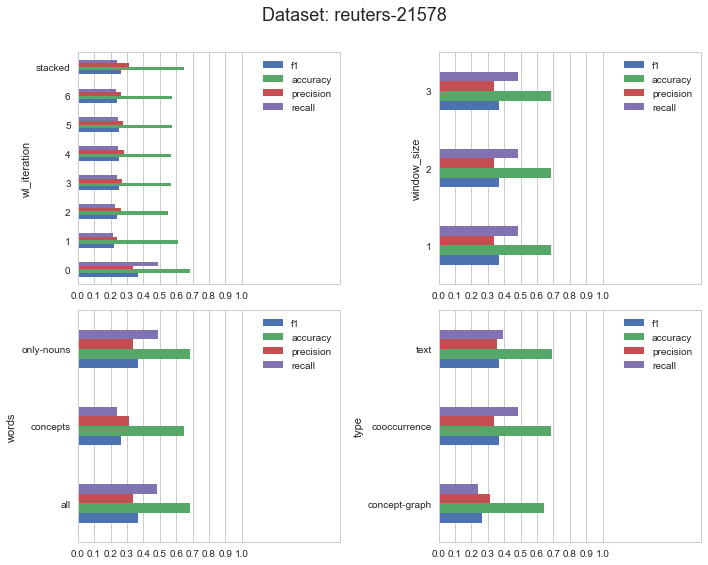

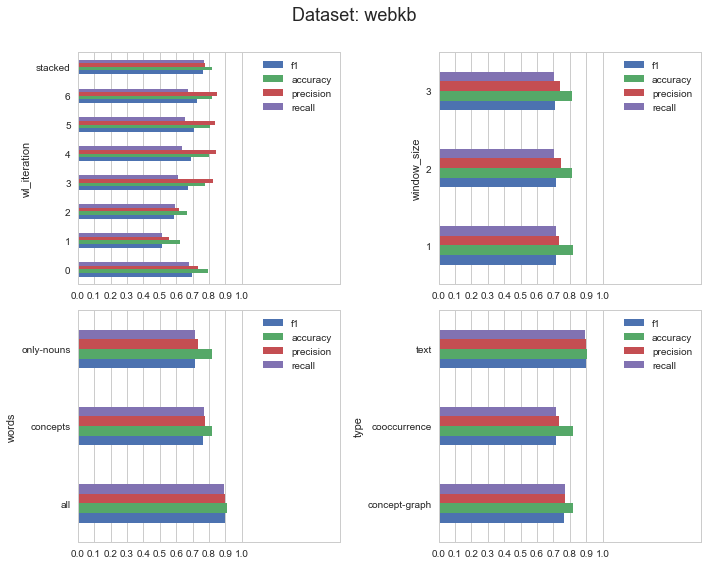

In [30]:
def plot_distributions(df, df_all, title = None, figsize = (10, 8)):
    fig, axes_indexed = plt.subplots(nrows = 2, ncols=2, figsize = figsize)

    axes = []
    for ax_row in axes_indexed:
        axes += list(ax_row)
    #, 'relabeled'
    for val, ax in zip(['wl_iteration', 'window_size', 'words', 'type'], axes):
        if len(df.groupby(val).size()) == 0:
            continue
        grouped = df.groupby(val)
        els = df_all.iloc[grouped['mean_test_f1_macro'].idxmax()]
        els = els.set_index(val)
        els = els.rename(columns = {'mean_test_f1_macro': 'f1', 'mean_test_accuracy': 'accuracy', 'mean_test_precision_macro': 'precision', 'mean_test_recall_macro': 'recall'})
        els[['f1', 'accuracy', 'precision', 'recall']].plot(kind = 'barh', ax = ax, xlim=(0, 2))
        ax.set_xticks(np.linspace(0, 1, 11))
        ax.grid(axis = 'y')
        ax.set_xlim((0, 1.6))
    
    plt.suptitle(title, size = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    return fig, axes
    
dpi = 150

if 1 == 1:
    fig, _  = plot_distributions(df_all, df_all, title = 'Mean over all datasets')
    fig.savefig('tmp/results/all.png', dpi = dpi)
    plt.show()
    plt.close(fig)
    for name, df_dataset in df_all.groupby('dataset'):
        if len(df_dataset.type.value_counts()) < 3:
            continue
        fig, _ = plot_distributions(df_dataset, df_all, title = 'Dataset: {}'.format(name))
        fig.savefig('tmp/results/dataset-{}.png'.format(name), dpi = dpi)
        plt.show()
        plt.close(fig)

import json

with open('data/check-w2v-results.json') as f:
    w2v_results = json.load(f)
 
per_embedding_type = {}
for dataset, value in w2v_results.items():
    print(dataset)
    for embedding_raw, cache_files in sorted(value.items(), key = lambda x: x[0]):
        embedding = embedding_raw.split('/')[-1].rsplit('.', 2)[0]
        if len(cache_files.keys()) != 2: continue
        print('\t{}'.format(embedding))
        if embedding not in per_embedding_type:
            per_embedding_type[embedding] = {}
        per_embemdding_type[embedding][dataset] = []
        for dataset_file, counts in sorted(cache_files.items(), key = lambda x: x[0]):
            not_found_ratio = int(counts['counts']['not_found'] / counts['num_labels'] * 100)
            if embedding == 'trained' and 'coo' in  dataset_file:
                print('Yes', counts['counts']['not_found'], not_found_ratio, '%', counts['not_found_sample'])
            is_gml = 'dataset_graph_gml' in dataset_file
            per_embedding_type[embedding][dataset].append((is_gml, not_found_ratio))
            print('\t\t{:4} missing  {:3>}%'.format('gml' if is_gml else 'co', not_found_ratio))
        per_embedding_type[embedding][dataset] = per_embedding_type[embedding][dataset][0][1]  #sum(y for x, y in per_embedding_type[embedding][dataset]) / 2
df = pd.DataFrame(per_embedding_type)
df#[df.index == "ng20"]

import dataset_helper
import matplotlib.pyplot as plt

currently = ['ling-spam', 'webkb', 'ng20', 'reuters-21578']

for dataset in dataset_helper.get_all_available_dataset_names():
    if dataset not in currently: continue
    X, Y = dataset_helper.get_dataset(dataset)
    unique_classes = set(Y)
    fig, ax = plt.subplots(figsize = (12, min(14, len(unique_classes) / 3)))
    print('{}\n#Docs:\t{}\t# Classes:\t{}'.format(dataset, len(X), len(unique_classes)))
    dataset_helper.plot_dataset_class_distribution(X, Y, 'Class distribution: {}'.format(dataset), ax = ax)
    plt.show()